<a href="https://colab.research.google.com/github/Yash0411/Pnuemonia-Detection-ML/blob/master/Pnuemonia_Detection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from google.colab import files
files.upload() #upload kaggle.json
 
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json
kaggle.json


In [2]:
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset

100% 1.18G/1.19G [00:19<00:00, 64.3MB/s]
100% 1.19G/1.19G [00:19<00:00, 66.6MB/s]


In [3]:
!unzip -q /content/coronahack-chest-xraydataset.zip -d .
!ls

Chest_xray_Corona_dataset_Summary.csv  coronahack-chest-xraydataset.zip
Chest_xray_Corona_Metadata.csv	       kaggle.json
Coronahack-Chest-XRay-Dataset	       sample_data


In [0]:
import os
for dirname, _, filenames in os.walk('/content/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
training_dir = os.listdir('/content/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train')
testing_dir = os.listdir('/content/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test')

print(len(training_dir))
print(len(testing_dir))


os.mkdir('data')


os.mkdir('data/training')
os.mkdir('data/testing')
os.mkdir('data/training/normal')
os.mkdir('data/training/pnuemonia')
os.mkdir('data/testing/normal')
os.mkdir('data/testing/pnuemonia')

data =  os.listdir('data')
print(len(data))

5309
624
2


In [0]:
import zipfile
import random
import tensorflow as tf
import shutil
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
import csv

def split_data(SOURCE, TRAINING_NORMAL_DIR, TESTING_NORMAL_DIR, TRAINING_AFFECT_DIR, TESTING_AFFECT_DIR, SPLIT_SIZE):

    #print(SOURCE, TRAINING_NORMAL_DIR, TESTING_NORMAL_DIR, TRAINING_AFFECT_DIR, TESTING_AFFECT_DIR, SPLIT_SIZE)
    affected=[]
    normal = []
    
    fname = "/content/Chest_xray_Corona_Metadata.csv"
    
    with open(fname, 'r') as csvfile:  
        csvreader = csv.reader(csvfile) 
      
        # extracting field names through first row 
        fields = next(csvreader) 
    
        for row in csvreader :
          file = SOURCE + row[1]
          label = row[2]
          #print(label,file)
          
            
          if os.path.exists(file):
            if os.path.getsize(file) > 0:
              if row[2] == "Normal":
                normal.append(row[1])
              else:
                affected.append(row[1])
                #files.append(filename)
            else:
              print(row + " is zero length, so ignoring.")
        
        
    aff_training_length = int(len(affected) * SPLIT_SIZE)
    aff_testing_length = int(len(affected) - aff_training_length)
    norm_training_length = int(len(normal) * SPLIT_SIZE)
    norm_testing_length = int(len(normal) - norm_training_length)
    
    shuffled_set_aff = random.sample(affected, len(affected))
    shuffled_set_norm = random.sample(normal, len(normal))
    
    aff_training_set = shuffled_set_aff[0:aff_training_length]
    aff_testing_set = shuffled_set_aff[-aff_testing_length:]   
    
    norm_training_set = shuffled_set_norm[0:norm_training_length]
    norm_testing_set = shuffled_set_norm[-norm_testing_length:] 
    
    for filename in aff_training_set:
        this_file = SOURCE + filename
        destination = TRAINING_AFFECT_DIR + filename
        copyfile(this_file, destination)

    for filename in aff_testing_set:
        this_file = SOURCE + filename
        destination = TESTING_AFFECT_DIR + filename
        copyfile(this_file, destination)
        
    for filename in norm_training_set:
        this_file = SOURCE + filename
        destination = TRAINING_NORMAL_DIR + filename
        copyfile(this_file, destination)

    for filename in norm_testing_set:
        this_file = SOURCE + filename
        destination = TESTING_NORMAL_DIR + filename
        copyfile(this_file, destination)

            



SOURCE_DIR = "/content/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/"
TRAINING_NORMAL_DIR = "/content/data/training/normal/"
TESTING_NORMAL_DIR = "/content/data/testing/normal/"
TRAINING_AFFECT_DIR = "/content/data/training/pnuemonia/"
TESTING_AFFECT_DIR = "/content/data/testing/pnuemonia/"

split_size = .9
split_data(SOURCE_DIR, TRAINING_NORMAL_DIR, TESTING_NORMAL_DIR,TRAINING_AFFECT_DIR, TESTING_AFFECT_DIR, split_size)

In [7]:
print(len(os.listdir(SOURCE_DIR)))
print(len(os.listdir(TRAINING_NORMAL_DIR)))
print(len(os.listdir(TESTING_NORMAL_DIR)))
print(len(os.listdir(TRAINING_AFFECT_DIR)))
print(len(os.listdir(TESTING_AFFECT_DIR)))

5309
1207
135
3549
395


In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), (2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), (2,2)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), (2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [21]:
TRAINING_DIR = "/content/data/training"
train_datagen = ImageDataGenerator( rescale=1./255.)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))


VALIDATION_DIR = "/content/data/testing"
validation_datagen = ImageDataGenerator(rescale = 1.0 / 255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                   batch_size = 10,
                                                   class_mode = "binary",
                                                   target_size = (150,150))

Found 4756 images belonging to 2 classes.
Found 530 images belonging to 2 classes.


In [22]:
history = model.fit(train_generator,
                              epochs=50,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/50
48/48 [==============================] - 54s 1s/step - loss: 0.6784 - acc: 0.7748 - val_loss: 0.2370 - val_acc: 0.9226
Epoch 2/50
48/48 [==============================] - 54s 1s/step - loss: 0.2200 - acc: 0.9186 - val_loss: 0.1242 - val_acc: 0.9604
Epoch 3/50
48/48 [==============================] - 54s 1s/step - loss: 0.1738 - acc: 0.9378 - val_loss: 0.1102 - val_acc: 0.9604
Epoch 4/50
48/48 [==============================] - 54s 1s/step - loss: 0.1469 - acc: 0.9447 - val_loss: 0.1024 - val_acc: 0.9660
Epoch 5/50
48/48 [==============================] - 53s 1s/step - loss: 0.1351 - acc: 0.9554 - val_loss: 0.1686 - val_acc: 0.9358
Epoch 6/50
48/48 [==============================] - 53s 1s/step - loss: 0.1120 - acc: 0.9611 - val_loss: 0.0910 - val_acc: 0.9736
Epoch 7/50
48/48 [==============================] - 53s 1s/step - loss: 0.0824 - acc: 0.9693 - val_loss: 0.0733 - val_acc: 0.9774
Epoch 8/50
48/48 [==============================] - 53s 1s/step - loss: 0.1068 - acc: 0.96

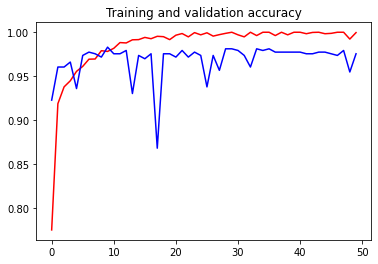

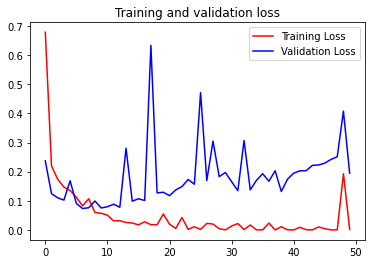

In [33]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
model.save("pnuemonia_detection.h5")